In [1]:
import os
import datetime
from covidcolombia.utils import colombia_demo_distribution, korea_cfr, parsing_string_regiones
from covidcolombia.constants import NAME_DEMO_DIST_COL, NAME_CFR_KOR, SUMMARY_NAME, NAME_TESTS_DB, INS_DEPTO_TO_TEST
from covidcolombia import Summary
import pandas as pd
from load_summary import get_summary
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def patched_dane2ins(region):
    if region == "COLOMBIA":
        return "Colombia"
    if region == "Bogotá D.C.":
        return "BOGOTA"
    elif region == "Guainía":
        return "GUAINIA"
    elif region == "Norte de Santander":
        return "NORTE SANTANDER"
    elif region == "Quindío":
        return "QUINDIO"
    elif region == 'San Andrés, Providencia y Santa Catalina (Archipiélago)' or region == 'Archipiélago de San Andrés':
        return "SAN ANDRES"
    elif region == "Vaupés":
        return "VAUPES"
    else:
        return parsing_string_regiones(region)

In [3]:
today = str(datetime.date.today())
summary_path = os.path.join('.', 'tmp', today, SUMMARY_NAME)
if os.path.isfile(summary_path):
    summary = get_summary(summary_path)
else:
    summary = get_summary(regions=None, date=today)
    
summary = summary[summary.rango == "(0-MAX_AGE)"]
summary_urep = summary[['urep', 'region', 'blCFR', 'cCFR']]

In [4]:
pib = pd.read_excel('../data/anexo-2019-preliminar-PIB-total-por-departamento.xlsx', sheet_name=3, header=8, nrows=34, engine='openpyxl')
pib.DEPARTAMENTOS = pib.DEPARTAMENTOS.apply(patched_dane2ins).values
pib_last = pib[["DEPARTAMENTOS", "2019pr"]].rename(columns = {'DEPARTAMENTOS':'region', '2019pr': 'PIB/capita'})

In [5]:
pob = pd.read_excel('../data/anexo-proyecciones-poblacion-departamental_Area2018-2050.xlsx', header=11, engine='openpyxl')
pob = pob[(pob["AÑO"] == 2018) & (pob["ÁREA GEOGRÁFICA"]=="Total")][["DPNOM", "Total"]]
pob = pob.rename(columns={"DPNOM": "region", "Total": "population"})
pob.region = pob.region.apply(patched_dane2ins)

In [6]:
pib_last

region    PIB/capita
0          Colombia  2.149438e+07
1          AMAZONAS  1.053311e+07
2         ANTIOQUIA  2.343713e+07
3            ARAUCA  2.054583e+07
4         ATLANTICO  1.775773e+07
5            BOGOTA  3.566189e+07
6           BOLIVAR  1.818881e+07
7            BOYACA  2.343709e+07
8            CALDAS  1.679680e+07
9           CAQUETA  1.078597e+07
10         CASANARE  3.851017e+07
11            CAUCA  1.279564e+07
12            CESAR  1.706804e+07
13            CHOCO  7.967694e+06
14          CORDOBA  1.029417e+07
15     CUNDINAMARCA  2.076234e+07
16          GUAINIA  8.291845e+06
17         GUAVIARE  1.031707e+07
18            HUILA  1.546533e+07
19          GUAJIRA  1.228539e+07
20        MAGDALENA  1.021757e+07
21             META  3.744116e+07
22           NARIÑO  9.807747e+06
23  NORTE SANTANDER  1.042698e+07
24         PUTUMAYO  1.159681e+07
25          QUINDIO  1.568890e+07
26        RISARALDA  1.790341e+07
27       SAN ANDRES  2.614184e+07
28        SANTANDER  3.069004e+07
29            SUCRE  9.469278e+06
30           TOLIMA  1.686888e+07
31            VALLE  2.289424e+07
32           VAUPES  7.157854e+06
33          VICHADA  6.317778e+06

In [7]:
tests = pd.read_csv(os.path.join('.', 'tmp', today, NAME_TESTS_DB))

In [8]:
def nbi2ins(region):
    if region == "BOGOTÁ, D.C.":
        return "BOGOTA"
    elif region == "LA GUAJIRA":
        return "GUAJIRA"
    elif region == 'NORTE DE SANTANDER':
        return "NORTE SANTANDER"
    elif region == "VALLE DEL CAUCA":
        return "VALLE"
    elif region == "ARCHIPIÉLAGO DE SAN ANDRÉS":
        return "SAN ANDRES"
    elif region == "TOTAL NACIONAL":
        return "Colombia"
    elif region == "CÓRDOBA ":
        return "CORDOBA"
    else:
        return unidecode.unidecode(region)

nbi = pd.read_excel('../data/CNPV-2018-NBI.xlsx', sheet_name=1, header=[7,8,9], nrows=34, engine='openpyxl')
deptos = nbi["Departamentos", "Nombre Departamento", "Unnamed: 1_level_2"].apply(nbi2ins)
nbitotal = nbi["Total", "Necesidades Basicas Insatisfechas por Categorias %"]
nbitotal["region"] = deptos

/home/vladimir/.local/share/virtualenvs/covid19-paper-6YLwofOT/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
<ipython-input-8-f01b5cc603cf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbitotal["region"] = deptos


In [9]:
urep_vs_pib = pd.merge(summary_urep, pib_last, on='region', how='inner')
urep_vs_pib = pd.merge(urep_vs_pib, pob, on='region', how='inner')
urep_vs_pib = pd.merge(urep_vs_pib, nbitotal, on='region', how='inner')

In [10]:
last_tests = pd.DataFrame(tests.iloc[-1]).reset_index()
acumulada_name = last_tests.columns[-1]
last_tests.rename(columns={"index": 'region', acumulada_name: 'tests'}, inplace=True)

In [11]:
def ins2tests(region):
    if region in INS_DEPTO_TO_TEST.keys():
        return INS_DEPTO_TO_TEST[region]
    else:
        return region

In [12]:
urep_vs_pib["region"] = urep_vs_pib.region.apply(ins2tests)

In [13]:
results = pd.merge(urep_vs_pib, last_tests, on='region', how='inner')

In [14]:
results["testsper100k"] = results.tests / ( results.population/100000 )
results.testsper100k = pd.to_numeric(results.testsper100k)
results.head()

urep           region     blCFR      cCFR    PIB/capita  population  \
0  55.279317        antioquia  1.236250  2.236375  2.343713e+07     6407102   
1  40.760656  valle_del_cauca  1.434480  3.519271  2.289424e+07     4475886   
2  36.970336        santander  1.248955  3.378242  3.069004e+07     2184837   
3  41.019495     cundinamarca  1.174701  2.863752  2.076234e+07     2919060   
4  43.919510           tolima  1.471423  3.350287  1.686888e+07     1330187   

   Prop de Personas en NBI (%)  Prop de Personas en miseria  \
0                    10.673352                     2.483760   
1                     6.183595                     0.676487   
2                     9.452724                     1.432108   
3                     6.259036                     0.724394   
4                    12.062916                     2.178727   

   Componente vivienda  Componente Servicios  Componente Hacinamiento  \
0             3.528589              1.885698                 2.726043   
1             0.701472              0.676966                 1.353480   
2             2.922397              0.855108                 2.485355   
3             1.413863              0.631249                 1.853549   
4             3.257084              1.608049                 3.415441   

   Componente Inasistencia  Componente dependencia económica   tests  \
0                 1.710581                          4.127376  711977   
1                 1.596793                          2.656537  393248   
2                 1.420913                          3.463956  220547   
3                 1.329169                          1.846831  195526   
4                 1.842793                          4.566078  105916   

   testsper100k  
0  11112.309434  
1   8785.925289  
2  10094.437251  
3   6698.252177  
4   7962.489485

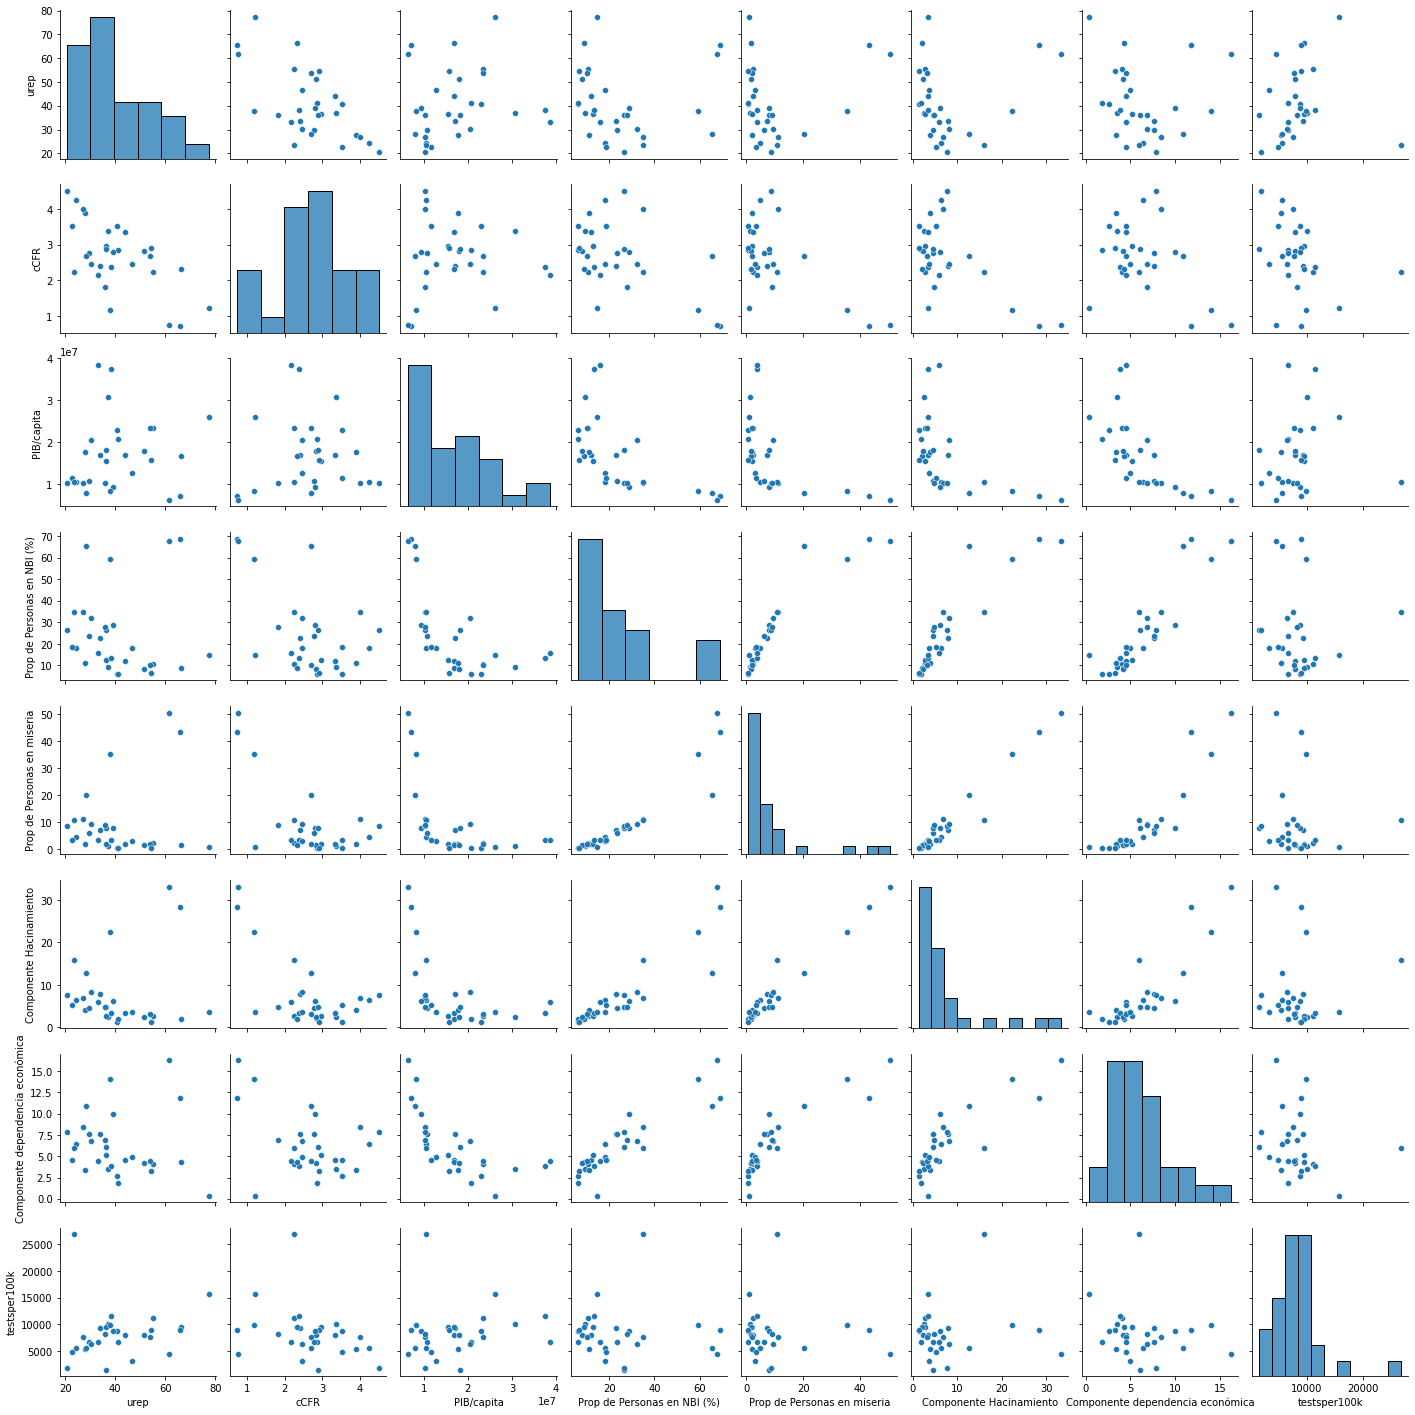

In [15]:
sns.pairplot(results.set_index('region')[['urep', 'cCFR', 'PIB/capita', "Prop de Personas en NBI (%)", "Prop de Personas en miseria", "Componente Hacinamiento", "Componente dependencia económica", "testsper100k"]])
plt.savefig('pairplot.png', dpi=400)

In [16]:
corr = results.set_index('region').corr()

#plt.show()

In [17]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)